In [1]:
import projetLib as proj
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Subset
import torchvision
from tqdm import tqdm
import sys

In [2]:
size = (224,224)
batch_size = 4
train,test = trainDataset, testDataset = proj.data.getTrainTest(
    resize=(224,224), batch_size=batch_size, seed=1,
    test_proportion=0.2, extensions=["pe","msdos","elf","other"])
dataloader = DataLoader(train, num_workers=2, batch_size=16, shuffle=True)

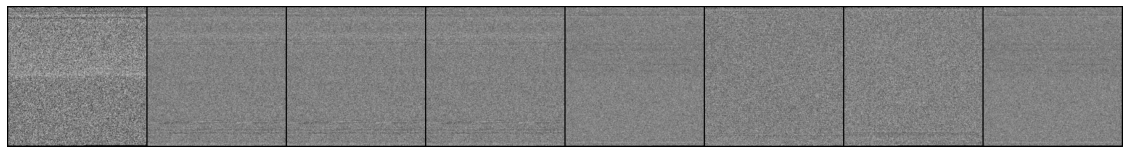

In [3]:
x,y  = next(iter(dataloader)) # On itére en général sur un dataloader avec une boucle pour récupérer des batch (de taille batch_size) mais on peut aussi récupérer seulement le premier batch comme ici
proj.utils.plot_img(x) # Affichage du premier batch

In [4]:
import pandas as pd
import torch.nn as nn
import numpy as np
from torchmetrics import ConfusionMatrix
import projetLib as proj
from torch.utils.data import DataLoader

testloader = DataLoader(testDataset, num_workers=2, batch_size=batch_size, shuffle=True)
model = proj.model.ENet()

with torch.no_grad():
    
    model.eval()
    matrix = torch.zeros((2,2))
    confmat = ConfusionMatrix(task="binary", num_classes=2)
    for x, y in testloader : 
        print(x.shape)
        #x = torch.cat((x, x, x), 1)
        print(x.shape)
        outputs = model(x)
        print(outputs.shape)
        outputs = torch.reshape(outputs,(len(y),))
        print(outputs)
        matrix  += confmat(outputs, y)

    (tp,fp),(fn,tn) = matrix
    accuracy = (tp+tn)/(tp+tn+fp+fn) 
    print(accuracy)
        
        #recall = tp/(tp+fn) # quelle proporition positif a été id correctement 
        #precision = tp/(tp+fp) # quelle proportion positif = correct


torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 128, 28, 28])


/home/thomas/.local/lib/python3.10/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


RuntimeError: shape '[4]' is invalid for input of size 401408

In [11]:
import projetLib as proj
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Subset
import torchvision
from tqdm import tqdm
import sys

batch_size = 4

trainDataset, testDataset = proj.data.getTrainTest(
    resize=(224,224), batch_size=batch_size, seed=1,
    test_proportion=0.2, extensions=["pe","msdos","elf","other"])
print(len(trainDataset),len(testDataset))

8 16


In [2]:
trainloader = DataLoader(trainDataset, num_workers=2, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testDataset, num_workers=2, batch_size=batch_size, shuffle=True)

for x,y in testloader : 
    print(y)

tensor([0, 0, 1, 0])
tensor([1, 0, 0, 0])
tensor([1, 0, 0, 0])
tensor([0, 0, 1, 0])


In [3]:
print(y)

tensor([0, 0, 1, 0])


In [4]:
y[y==0] = -1
print(y)

tensor([-1, -1,  1, -1])
